In [28]:
# Import necessary libraries
from neo4j import GraphDatabase
import pandas as pd


URI = "bolt://localhost:7687/neo4j"  
USERNAME = "neo4j"
PASSWORD = ""

# Create a connection driver to the Neo4j database
driver = GraphDatabase.driver(URI, auth=(USERNAME, PASSWORD))

def run_query(query, params={}):
    """
    Executes a Cypher query on the Neo4j database.
    
    :param query: Cypher query string
    :param params: Dictionary of query parameters (default: empty dictionary)
    :return: List of records as dictionaries
    """
    with driver.session() as session:
        result = session.run(query, **params)  # Execute the query
        print("Query run is successful")
        return [record.data() for record in result]  # Convert results to a list of dictionaries
    

def show_results(results):
    """
    Displays query results as a Pandas DataFrame.
    
    :param results: List of query result dictionaries
    """
    df = pd.DataFrame(results)  # Convert results to a DataFrame
    return df  # Print the DataFrame for visualization


In [29]:
# To retrieve nodes and relationships
query = """
MATCH (n)-[r]->(m)
RETURN n, r, m
LIMIT 100;

"""

# Execute the query and display results
results = run_query(query)
print(results)

Query run is successful
[{'n': {'Amount': 100.5, 'PurchaseDatetime': neo4j.time.DateTime(2024, 3, 15, 10, 30, 0, 0, tzinfo=<UTC>), 'TransactionID': 'TransactionID'}, 'r': ({'Amount': 100.5, 'PurchaseDatetime': neo4j.time.DateTime(2024, 3, 15, 10, 30, 0, 0, tzinfo=<UTC>), 'TransactionID': 'TransactionID'}, 'MADE_AT', {'MerchantName': 'Merchant'}), 'm': {'MerchantName': 'Merchant'}}, {'n': {'CardNumber': '1234567890123456', 'CustomerID': 'CIF'}, 'r': ({'CardNumber': '1234567890123456', 'CustomerID': 'CIF'}, 'USED_FOR', {'Amount': 100.5, 'PurchaseDatetime': neo4j.time.DateTime(2024, 3, 15, 10, 30, 0, 0, tzinfo=<UTC>), 'TransactionID': 'TransactionID'}), 'm': {'Amount': 100.5, 'PurchaseDatetime': neo4j.time.DateTime(2024, 3, 15, 10, 30, 0, 0, tzinfo=<UTC>), 'TransactionID': 'TransactionID'}}, {'n': {'Address': '123 Street, NY', 'FirstName': 'John', 'Country': 'USA', 'PhoneNumber': '1234567890', 'CustomerID': 'CIF', 'Gender': 'Male', 'LastName': 'Doe', 'JobTitle': 'Engineer', 'Age': 30, 'Em

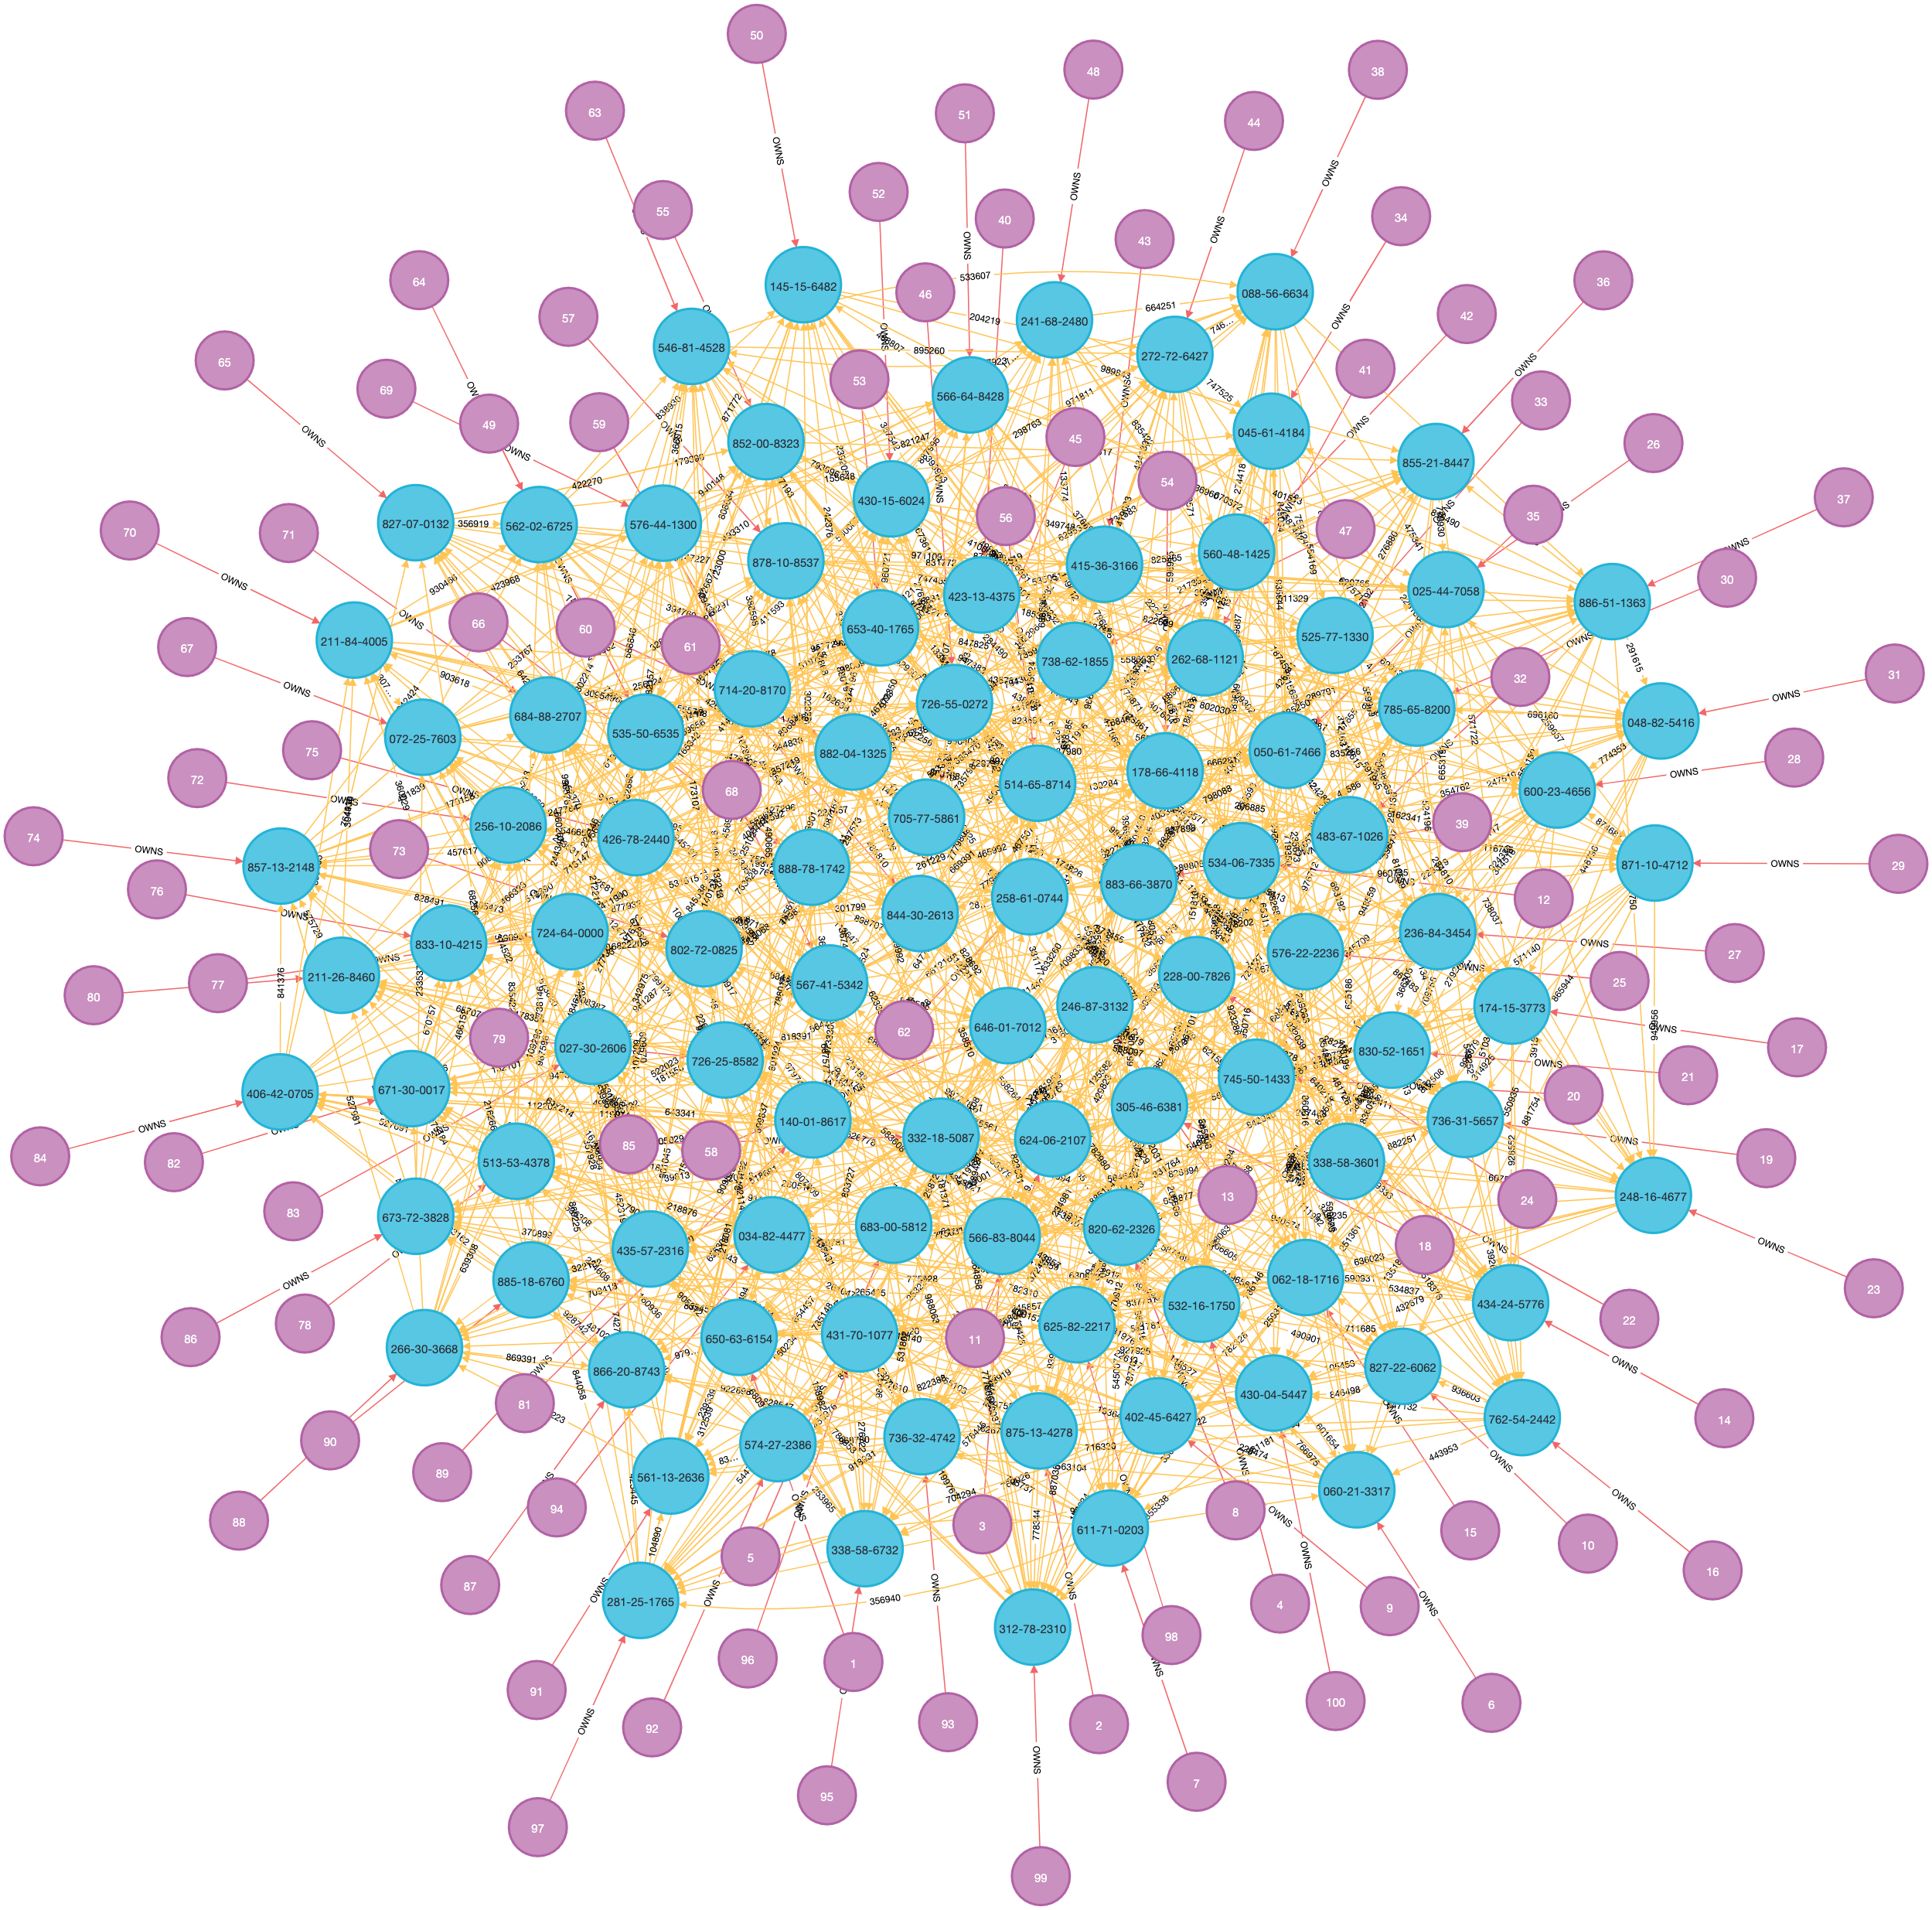

# 3. Cypher Query development

### Pattern Detection

In [5]:
# Identify accounts with unusually high outgoing transactions
query = """
MATCH (a:Account)-[t:TRANSFERRED_TO]->(b:Account)  //Find all outgoing transactions
WITH a, 
     count(t) AS transaction_count,               //Count the number of transactions from an account
     round(sum(t.Amount),2) AS total_amount       //Calculate the total transferred amount
WHERE transaction_count >= 10                     //Flag accounts with >=10 transactions
  AND total_amount > 100000                       //Flag accounts with >100K transferred amount
RETURN a.CustomerID AS Customer, 
       a.AccountNumber AS Account, 
       transaction_count, 
       total_amount
ORDER BY total_amount DESC;                        //Sort by the highest total transferred amount
"""

# Execute the query and display results
results = run_query(query)
df = show_results(results)
df.head(10)

Query run is successful


Customer      Account  transaction_count  total_amount
0       94  034-82-4477                 10    1338239.11
1       62  258-61-0744                 10    1337661.78
2       58  646-01-7012                 10    1336486.01
3       56  514-65-8714                 10    1263042.57
4       38  088-56-6634                 10    1258624.51
5        2  875-13-4278                 10    1240666.00
6       32  483-67-1026                 10    1226040.50
7       43  415-36-3166                 10    1202537.36
8       21  830-52-1651                 10    1169269.74
9       98  625-82-2217                 10    1147751.11

In [6]:
# Multi-hop queries for fraud detection| Detect Money Laundering/Circular Trading| Multi-hop transaction tracing in Transfers Table (3-hop)
query = """
MATCH p=(a:Account)-[:TRANSFERRED_TO*3..12]->(a)  //Find transactions forming cycles (3 to 12 hops)
RETURN p 
LIMIT 5;                                          //Limit results to 5 for initial analysis
"""

# Execute the query and display results
results = run_query(query)
df = show_results(results)
df.head(10)


Query run is successful


p
0  [{'CustomerID': '1', 'AccountNumber': '650-63-...
1  [{'CustomerID': '1', 'AccountNumber': '650-63-...
2  [{'CustomerID': '1', 'AccountNumber': '650-63-...
3  [{'CustomerID': '1', 'AccountNumber': '650-63-...
4  [{'CustomerID': '1', 'AccountNumber': '650-63-...

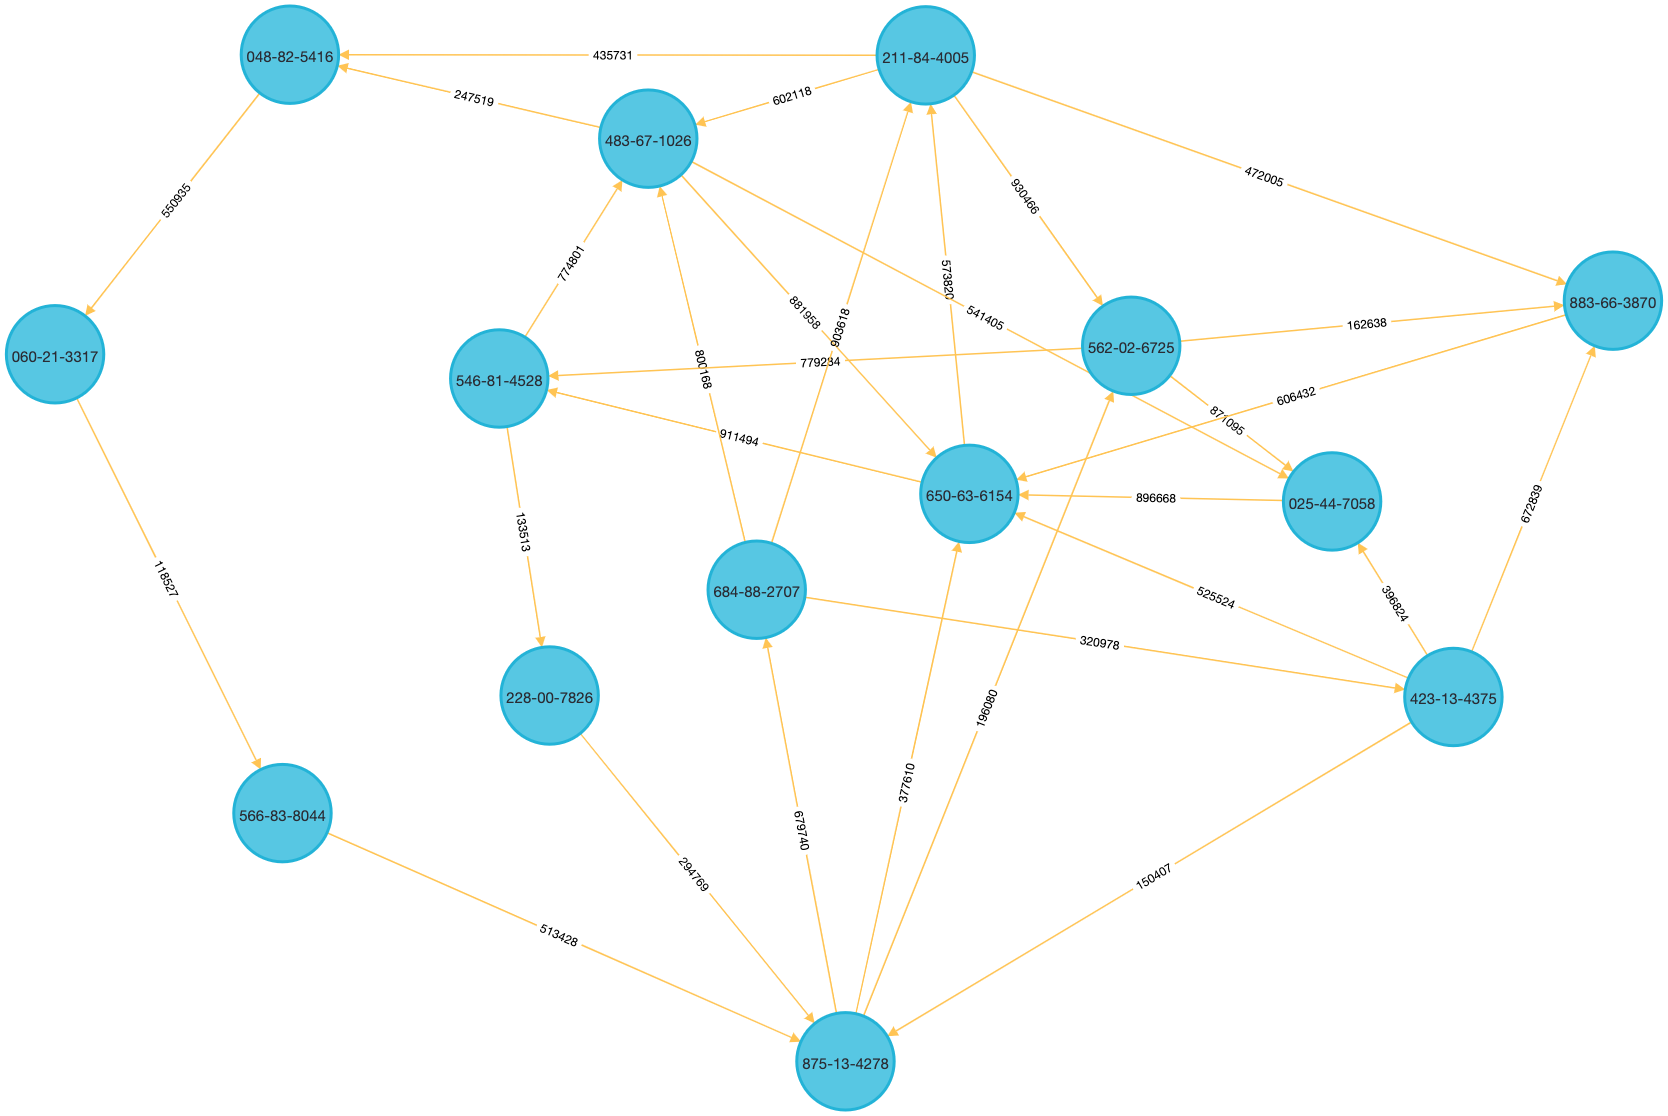

In [7]:
# Identifying suspicious multi-hop money movement (4-hop fraud detection)
# Detects if money is moving through 4 intermediary accounts in a loop or unusual flow
query = """
MATCH (a1:Account)-[:TRANSFERRED_TO]->(a2:Account)
      -[:TRANSFERRED_TO]->(a3:Account)
      -[:TRANSFERRED_TO]->(a4:Account)
      -[:TRANSFERRED_TO]->(a5:Account)  //Tracking 4-hop transfers

WHERE a1 = a5                           //Ensuring the money isn't returning to the source
RETURN a1.AccountNumber AS Origin, 
       a5.AccountNumber AS FinalDestination, 
       COUNT(*) AS HopCount;
"""

# Execute the query and display results
results = run_query(query)
df = show_results(results)
df.head(10)

Query run is successful


Origin FinalDestination  HopCount
0  875-13-4278      875-13-4278        88
1  532-16-1750      532-16-1750        60
2  611-71-0203      611-71-0203        59
3  624-06-2107      624-06-2107        60
4  062-18-1716      062-18-1716        68
5  745-50-1433      745-50-1433        66
6  025-44-7058      025-44-7058        58
7  483-67-1026      483-67-1026        69
8  883-66-3870      883-66-3870        68
9  423-13-4375      423-13-4375        65

In [8]:
# Detecting customers making multiple purchases linked to fraud merchants within 30 days
query = """
MATCH (c1:Customer)-[:LINKED_TO]-(c:Card)-[:USED_FOR]->(t1:Purchase)-[:MADE_AT]->(f:Merchant),
      (c:Card)-[:USED_FOR]->(t2:Purchase)-[:MADE_AT]->(f)                             //Find multiple purchases at the same merchant

WHERE t1.PurchaseDatetime < t2.PurchaseDatetime                                      //Ensure chronological order of transactions
AND duration.between(t1.PurchaseDatetime, t2.PurchaseDatetime).days <= 30           //Limit to a 30-day window

WITH c.CardNumber AS Card, 
     f.MerchantName AS Merchant, 
     COLLECT(DISTINCT t2.TransactionID) AS Transactions                            //Collect distinct transaction IDs

RETURN Card, 
       Merchant, 
       SIZE(Transactions) AS PurchaseCount                                        //Count number of purchases
ORDER BY PurchaseCount DESC                                                      //Prioritize frequent transactions at flagged merchants
LIMIT 5;                                                                        //Retrieve top 5 cases for analysis
"""

# Execute the query and display results
results = run_query(query)
df = show_results(results)
df.head(10)

Query run is successful


Card     Merchant  PurchaseCount
0  425-86-2712        AECOM             13
1  773-80-8680     Vodafone             11
2  348-14-6088  Areon Impex             11
3  171-24-1530     Erickson             11
4  285-83-6186         Mars             11

### Customer Segmentation

In [10]:
# Customer Segmentation: Categorize customers based on transaction volume and spending
query = """
MATCH (c:Customer)-[:OWNS]->(a:Account)-[t:TRANSFERRED_TO]->(:Account)  //Find transactions linked to customer accounts
WITH c, 
     count(t) AS transaction_count,                                     //Count total transactions per customer
     round(sum(t.Amount),2) AS total_spent                              //Calculate total amount transferred

RETURN c.CustomerID AS Customer, 
       CASE 
           WHEN total_spent > 500000 THEN 'High Value'                  //Customers spending more than 500K
           WHEN total_spent > 100000 THEN 'Medium Value'                //Customers spending between 100K and 500K
           ELSE 'Low Value'                                             //Customers spending less than 100K
       END AS Customer_Segment, 
       total_spent, 
       transaction_count;
"""

# Execute the query and display results
results = run_query(query)
df = show_results(results)
df.head(10)

Query run is successful


Customer Customer_Segment  total_spent  transaction_count
0        1       High Value    998087.92                  9
1        2       High Value   1240666.00                 10
2        3       High Value    888298.50                  9
3        4       High Value    790909.15                  9
4        5       High Value    626140.24                  9
5        6       High Value   1051131.62                  9
6        7       High Value    823237.20                  9
7        8       High Value    800288.13                  9
8        9       High Value   1157261.19                  9
9       10       High Value   1018455.28                  9

In [16]:
# // Customer Segmentation: Categorizing customers based on transaction volume  
# // Incorporating total spending, transaction count, and segmentation labels  
query = """  

MATCH (c:Customer)-[:LINKED_TO]->(cd:Card)-[:USED_FOR]->(t:Purchase)           //Identify customers making purchases  

WITH c, COUNT(Distinct t.TransactionID) AS transaction_count, round(SUM(t.Amount),2) AS total_spent  //Aggregate total transactions and spending  

RETURN   
    c.CustomerID AS Customer,                                                             //Unique customer identifier  
    c.FirstName AS Name,                                                              //Customer's first name  
    transaction_count,                                                        //Total number of transactions made  
    total_spent,                                                              //Total amount spent by the customer  
    CASE   
        WHEN total_spent > 1000000 THEN 'VIP'                                 //Customers spending over 1M  
        WHEN total_spent > 500000 THEN 'High Value'                           //Spending between 500K and 1M  
        WHEN total_spent > 100000 THEN 'Medium Value'                         //Spending between 100K and 500K  
        ELSE 'Low Value'                                                      //Spending below 100K  
    END AS Customer_Segment                                                   //Categorizing customers into different segments  
ORDER BY total_spent DESC;                                                    //Prioritizing high-spending customers  

"""

# Execute the query and display results  
results = run_query(query)  
df = show_results(results)
df.head(10) 

Query run is successful


Customer     Name  transaction_count  total_spent Customer_Segment
0        1    Greta                179   1978438.38              VIP
1        5    Erick                178   1917779.07              VIP
2        3     Dani                179   1882640.27              VIP
3       11     Matt                179   1817368.14              VIP
4        8  Candace                179   1815146.21              VIP
5        6   Hayden                179   1775603.05              VIP
6        9    Rowan                179   1770381.45              VIP
7        2  Rebecca                179   1766145.78              VIP
8        4   Morgan                179   1751035.44              VIP
9        7     Mark                179   1732153.13              VIP

### Tracing Relationships

In [17]:
# Tracing Relationships: Find the shortest path between two accounts
query = """  

MATCH path = shortestPath(  
    (a1:Account {AccountNumber: '246-87-3132'})-[:TRANSFERRED_TO*..5]-(a2:Account {AccountNumber: '305-46-6381'})  
)                                                                  //Find the shortest path between two accounts with a max depth of 5  

RETURN path;                                                      //Return the transaction path between the two accounts  

"""  

# Execute the query and display results  
results = run_query(query)  
df = show_results(results)
df.head(10)

Query run is successful


path
0  [{'CustomerID': '13', 'AccountNumber': '246-87...

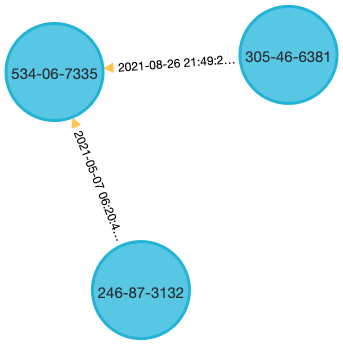

In [19]:
# // Identifying Influential Accounts: Rank accounts by transaction influence  
# // Influence is measured based on the number of outgoing transactions  
query = """  

MATCH (a:Account)-[t:TRANSFERRED_TO]->(b:Account)  //Find accounts involved in transfers  

WITH a, count(t) AS influence_score                //Count the number of transactions per account as the influence score  

RETURN a.AccountNumber AS AccountNumber, influence_score            //Return the account number along with its influence score  
ORDER BY influence_score DESC                      //Rank accounts in descending order of influence  
LIMIT 10;                                          //Retrieve the top 10 most influential accounts  

"""  

# Execute the query and display results  
results = run_query(query)  
df = show_results(results)
df.head(10)

Query run is successful


AccountNumber  influence_score
0   174-15-3773               10
1   338-58-3601               10
2   534-06-7335               10
3   762-54-2442               10
4   745-50-1433               10
5   830-52-1651               10
6   875-13-4278               10
7   624-06-2107               10
8   062-18-1716               10
9   248-16-4677               10

### Aggregated Analytics

In [20]:
# Trend Analysis: Find monthly transaction trends  
# Aggregating total transactions per month to analyze financial patterns  

query = """  

MATCH (a:Account)-[t:TRANSFERRED_TO]->(b:Account)                                              //Identify money transfers between accounts  

WITH datetime(t.TransferDatetime) AS transaction_date, round(t.Amount, 2) AS total_transacted  //Convert to datetime and round amount  

RETURN transaction_date.year AS Year,                   //Extract the year from the transaction date  
       transaction_date.month AS Month,                 //Extract the month from the transaction date  
       sum(total_transacted) AS Monthly_Total           //Calculate total transaction amount for each month  

ORDER BY Year, Month;                           

"""  

# Execute the query and display results  
results = run_query(query)  
df = show_results(results)  
df.head(10)

Query run is successful


Year  Month  Monthly_Total
0  2021      1    11796755.62
1  2021      2    11409772.64
2  2021      3    13580474.50
3  2021      4    10113213.51
4  2021      5    11643244.12
5  2021      6    13226476.93
6  2021      7    10325498.76
7  2021      8    11339399.30
8  2021      9     2053321.92

In [22]:
# Trend Analysis: Find monthly transaction trends
query = """  

MATCH (c:Customer)-[:OWNS]->(a:Account)-[t:TRANSFERRED_TO]->(:Account)          //Link customers to their account transactions  

RETURN c.CustomerID AS Customer,                                                            //Retrieve unique customer ID  
       count(t) AS TransactionCount,                                            //Count the number of transactions per customer  
       round(SUM(t.Amount),2) AS TotalTransactions                                       //Calculate the total transaction amount per customer  

ORDER BY TotalTransactions DESC;    

"""  

# Execute the query and display results  
results = run_query(query)  
df = show_results(results)  
df.head(10)

Query run is successful


Customer  TransactionCount  TotalTransactions
0       94                10         1338239.11
1       62                10         1337661.78
2       58                10         1336486.01
3       56                10         1263042.57
4       38                10         1258624.51
5        2                10         1240666.00
6       32                10         1226040.50
7       43                10         1202537.36
8       21                10         1169269.74
9        9                 9         1157261.19

In [24]:
# Trend Analysis: Find monthly transaction trends
query= """
MATCH (m:Merchant)<-[:MADE_AT]-(p:Purchase)
RETURN m.MerchantName AS MerchantName, COUNT(p) AS PurchaseCount, round(SUM(p.Amount),2) AS TotalSpent
ORDER BY TotalSpent DESC
LIMIT 5;
"""
results = run_query(query)
df = show_results(results)  
df.head(10)

Query run is successful


MerchantName  PurchaseCount  TotalSpent
0    It Smart Group            370  3764334.78
1       Areon Impex            355  3617481.10
2  21st Century Fox            348  3590733.55
3          Vodafone            354  3559181.68
4        Amazon.com            347  3552105.29

In [26]:
# Trend Analysis: Find monthly transaction trends
query= """

MATCH (c:Customer)-[:OWNS]->(a:Account)-[t:TRANSFERRED_TO]->(:Account)
RETURN c.CustomerID AS CustomerID, count(t) as TransactionCount, round(SUM(t.Amount),2) AS TotalTransactions ORDER BY TotalTransactions DESC;

"""
results = run_query(query)
df = show_results(results)  
df.head(10)

Query run is successful


CustomerID  TransactionCount  TotalTransactions
0         94                10         1338239.11
1         62                10         1337661.78
2         58                10         1336486.01
3         56                10         1263042.57
4         38                10         1258624.51
5          2                10         1240666.00
6         32                10         1226040.50
7         43                10         1202537.36
8         21                10         1169269.74
9          9                 9         1157261.19

In [27]:
# Analyzing account transaction activity  
#Identifying total incoming and outgoing transactions for each account 
query = """  

MATCH (a:Account)                                      //Retrieve all accounts  

OPTIONAL MATCH (a)-[t_out:TRANSFERRED_TO]->(:Account) //Find outgoing transactions  
OPTIONAL MATCH (:Account)-[t_in:TRANSFERRED_TO]->(a)  //Find incoming transactions  

WITH a,  
     COUNT(DISTINCT t_out) AS outgoing_count,               //Count unique outgoing transactions  
     COUNT(DISTINCT t_in) AS incoming_count,                //Count unique incoming transactions  
     round(SUM(DISTINCT t_out.Amount),2) AS outgoing_total, //Sum total outgoing amount  
     round(SUM(DISTINCT t_in.Amount),2) AS incoming_total   //Sum total incoming amount  

RETURN a.AccountNumber AS account_number,                        //Return the account number  
       outgoing_count, incoming_count,                           //Number of outgoing and incoming transactions  
       outgoing_total, incoming_total,                           //Total value of outgoing and incoming transactions  
       (outgoing_count + incoming_count) AS total_transactions  //Calculate total transactions  

ORDER BY total_transactions DESC, (outgoing_total + incoming_total) DESC  //Rank by transaction volume and value  
LIMIT 10;   

"""  

# Execute the query and display results  
results = run_query(query)  
df = show_results(results)  
df.head(10)

Query run is successful


account_number  outgoing_count  incoming_count  outgoing_total  \
0    875-13-4278              10              13      1240666.00   
1    258-61-0744              10              13      1337661.78   
2    566-83-8044               9              14       888298.50   
3    430-04-5447              10              12      1019512.76   
4    546-81-4528              10              12       911860.55   
5    745-50-1433              10              11       971048.75   
6    312-78-2310              10              11       932794.31   
7    830-52-1651              10              11      1169269.74   
8    871-10-4712              10              10      1090967.48   
9    514-65-8714              10              10      1263042.57   

   incoming_total  total_transactions  
0      1436589.31                  23  
1      1246824.93                  23  
2      1440579.33                  23  
3      1118941.35                  22  
4      1212236.35                  22  
5      1211862.08                  21  
6       996239.50                  21  
7       748572.63                  21  
8      1252665.16                  20  
9      1059409.09                  20

# 4. Graph Data Science

Graph Data Science is a powerful tool in Neo4j through which advanced graph analytics can be used to uncover hidden patterns in financial transactions. There are different applications of GDS in Banking domain like - 
 - ⁠Identifying influential accounts in a transaction network.
 - ⁠Detecting fraudulent activities such as money laundering or Fraud Rings.
 - ⁠Clustering accounts based on transaction/Purchase behavior.

Graph Data Science provided deep insights into transaction behaviors, uncovering fraudulent activities that traditional RDBMS based analysis might miss. The combination of different graph algorithms like PageRank, community detection, and centrality measures enabled a comprehensive fraud detection framework. 

Additional algorithms can be leveraged to extend the analysis further and include predictive analysis, anomaly detection models, temporal transaction analysis, customer de-duplication, and real-time fraud monitoring, etc.



In [33]:
#Creating and listing a projected graph for banking transactions  
#Projecting nodes and relationships into a named graph for analysis  
query= """

CALL gds.graph.project(
  'BankingGraph',  
  ['Customer', 'Account', 'Card', 'Merchant', 'Purchase'], 
  ['OWNS', 'LINKED_TO', 'USED_FOR','MADE_AT', 'TRANSFERRED_TO']
  
);

"""
results = run_query(query)

df = show_results(results)
df.head(10)

Query run is successful


nodeProjection  \
0  {'Customer': {'label': 'Customer', 'properties...   

                              relationshipProjection     graphName  nodeCount  \
0  {'MADE_AT': {'aggregation': 'DEFAULT', 'orient...  BankingGraph      10293   

   relationshipCount  projectMillis  
0              21104             41

In [34]:
query= """

CALL gds.graph.list();

"""
results = run_query(query)
df = show_results(results)
df.head(10)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.list' is deprecated.)} {position: line: 3, column: 1, offset: 2} for query: '\n\nCALL gds.graph.list();\n\n'


Query run is successful


degreeDistribution     graphName database  \
0  {'min': 0, 'max': 10, 'p90': 2, 'p999': 10, 'p...  BankingGraph    neo4j   

  databaseLocation memoryUsage  sizeInBytes  nodeCount  relationshipCount  \
0            local    7193 KiB      7365674      10293              21104   

                                       configuration   density  \
0  {'relationshipProjection': {'MADE_AT': {'aggre...  0.000199   

                          creationTime                     modificationTime  \
0  2025-03-17T04:04:09.524783000+05:30  2025-03-17T04:04:09.524783000+05:30   

                                              schema  \
0  {'graphProperties': {}, 'nodes': {'Customer': ...   

                               schemaWithOrientation  
0  {'graphProperties': {}, 'nodes': {'Customer': ...

### PageRank Algorithm 

PageRank is an algorithm used by Google Search to rank websites in their search engine results. PageRank is a way of measuring the importance of website pages and in Banking domain, it helps in identifying influential accounts based on transaction connectivity.



In [36]:

#Identifying Influential Accounts using PageRank Algorithm
#PageRank measures the influence of accounts based on transaction connectivity
query = """  

CALL gds.pageRank.stream('BankingGraph')     //Run the PageRank algorithm on the projected graph  
YIELD nodeId, score                          //Extract node ID and PageRank score  
WHERE gds.util.asNode(nodeId).AccountNumber IS NOT NULL
RETURN gds.util.asNode(nodeId).AccountNumber AS Account, 
    score AS InfluenceScore, 
    CASE WHEN score > 0.5 THEN 'High'
            WHEN score > 0.2 THEN 'Medium'
            ELSE 'Low' END AS RiskCategory
ORDER BY InfluenceScore DESC                //Rank accounts by influence score in descending order  
LIMIT 10;

"""  

# Execute the query and display results  
results = run_query(query)  
df = show_results(results)
df.head(10)

Query run is successful


Account  InfluenceScore RiskCategory
0  430-04-5447        2.995880         High
1  566-83-8044        2.550761         High
2  312-78-2310        2.510648         High
3  875-13-4278        2.326698         High
4  258-61-0744        2.248564         High
5  745-50-1433        2.207641         High
6  830-52-1651        2.186530         High
7  532-16-1750        2.054672         High
8  625-82-2217        2.024298         High
9  546-81-4528        1.970419         High

###  Louvain Community Detection

Louvain Community Detection algorithm clusters accounts into groups based on transaction interactions and identifies fraud rings and suspicious account groups.


In [39]:
#Community Detection using Louvain Algorithm  
#Louvain algorithm detects clusters of accounts based on transaction patterns  

query= """
CALL gds.louvain.stream('BankingGraph')
YIELD nodeId, communityId
WITH gds.util.asNode(nodeId) AS node, communityId
WHERE labels(node) = ['Card']  // Ensure only Card nodes are considered
WITH communityId, COLLECT(node.CardNumber) AS cards, COUNT(*) AS clusterSize
WHERE clusterSize > 3  // Filter meaningful clusters
RETURN communityId, clusterSize, cards
ORDER BY clusterSize DESC;
"""
results = run_query(query)
df = show_results(results)
df.head(10)

Query run is successful


communityId  clusterSize                                              cards
0          195            7  [285-83-6186, 830-04-7362, 778-08-5267, 667-88...
1          136            7  [811-84-3310, 145-28-6565, 105-78-4218, 865-72...
2          188            7  [171-24-1530, 853-42-5384, 084-76-7037, 824-65...
3          164            7  [110-44-7471, 425-86-2712, 355-41-2463, 347-47...
4          149            4  [773-80-8680, 745-84-5503, 542-35-2342, 011-20...
5          168            4  [564-28-0407, 322-56-6040, 837-86-6353, 636-02...
6          197            4  [077-14-3850, 112-63-6481, 682-81-7633, 170-78...
7          204            4  [748-68-5701, 664-42-2061, 481-16-5303, 160-61...
8          177            4  [031-57-1657, 362-64-7780, 624-13-0454, 773-36...
9          190            4  [702-72-3427, 117-77-0065, 461-25-2550, 842-34...

### Betweenness Centrality

This algorithm measures how often an account acts as a bridge between transactions. It identifies key intermediary accounts that may be involved in layered transactions or money laundering.


In [38]:
# Identifying Key Accounts using Betweenness Centrality
#Betweenness Centrality measures how often an account acts as a bridge in transactions  
query= """
CALL gds.betweenness.stream('BankingGraph')
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).AccountNumber AS Account, score
ORDER BY score DESC
LIMIT 10;

"""

# Execute the query and display results  
results = run_query(query)  
df = show_results(results)
df.head(10)

Query run is successful


Account       score
0  430-04-5447  572.885309
1  566-83-8044  537.569471
2  875-13-4278  519.660917
3  258-61-0744  514.643022
4  312-78-2310  504.985734
5  546-81-4528  455.702410
6  532-16-1750  433.643461
7  745-50-1433  428.653670
8  830-52-1651  414.026473
9  625-82-2217  410.678469

In [41]:
# Find accounts with similar transaction patterns using Node Similarity
 
query= """
CALL gds.nodeSimilarity.stream('BankingGraph')
YIELD node1, node2, similarity
WHERE similarity > 0.1
WITH gds.util.asNode(node1) AS account1, gds.util.asNode(node2) AS account2, similarity
WHERE account1:Account AND account2:Account
RETURN account1.AccountNumber AS Account1, account2.AccountNumber AS Account2, 
       similarity AS PatternSimilarity
ORDER BY PatternSimilarity DESC
LIMIT 20;


"""

# Execute the query and display results  
results = run_query(query)  
df = show_results(results)
df.head(10)

Query run is successful


Account1     Account2  PatternSimilarity
0  762-54-2442  566-83-8044           0.266667
1  785-65-8200  174-15-3773           0.266667
2  566-83-8044  762-54-2442           0.266667
3  174-15-3773  785-65-8200           0.266667
4  745-50-1433  525-77-1330           0.250000
5  830-52-1651  600-23-4656           0.250000
6  830-52-1651  045-61-4184           0.250000
7  045-61-4184  830-52-1651           0.250000
8  062-18-1716  875-13-4278           0.250000
9  875-13-4278  062-18-1716           0.250000